## 1. Preliminary data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report , precision_score, roc_curve, auc
from sklearn.naive_bayes import ComplementNB, BernoulliNB, GaussianNB
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import shap

In [2]:
#import data
url="https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv"
df=pd.read_csv(url)
df_copy=df.copy()
print(df.shape)
df.head()

(338427, 19)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,424380.57,Working,Higher education,Civil marriage,Rented apartment,-11778.0,-4438.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,5008805,M,Y,Y,0,421593.52,Working,Higher education,Civil marriage,Rented apartment,-11777.0,-4459.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,5008806,M,Y,Y,0,110958.51,Working,Secondary / secondary special,Married,House / apartment,-21471.0,-1144.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,5008808,F,N,Y,0,267497.96,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18489.0,-3122.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,5008809,F,N,Y,0,263419.09,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19093.0,-3070.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


The dataset includes the following variables:
- **ID:** Customer identification number
- **CODE_GENDER:** Client's gender (Nominal categorical variable)
- **FLAG_OWN_CAR:**
indicator of car ownership (Binary categorical variable)
- **FLAG_OWN_REALTY:**
home ownership indicator (Binary categorical variable)
- **CNT_CHILDREN:** number of children (Quantitative variable)
- **AMT_INCOME_TOTAL:** Annual income (Quantitative variable)
- **NAME_INCOME_TYPE:** Type of income (Nominal categorical variable)
- **NAME_EDUCATION_TYPE:** Education level (Ordinal nominal variable)
- **NAME_FAMILY_STATUS:** Marital status (Nominal categorical variable)
- **NAME_HOUSING_TYPE:**
type of dwelling (Nominal categorical variable)
- **DAYS_BIRTH:**
number of days since birth (Quantitative variable)
- **DAYS_EMPLOYED:**
number of days since date of hiring (if positive, indicates the number of days since you have been unemployed) (Quantitative variable)
- **FLAG_MOBIL:** indicator of the presence of a mobile number (Binary variable)
- **FLAG_WORK_PHONE:** indicator of the presence of a work telephone number (Binary variable)
- **FLAG_PHONE:**
indicator of the presence of a telephone number (Binary variable)
- **FLAG_EMAIL:**
indicator of the presence of an email address (Binary variable)
- **OCCUPATION_TYPE:** Type of occupation (Nominal categorical variable)
- **CNT_FAM_MEMBERS:** number of family members (Quantitative variable)
-**TARGET:** Target variable that is equal to 1 if the customer has a high credit rating (constant payment of installments), 0 otherwise

For numeric variables it is possible to evaluate summary statistics.


In [3]:
num_column=['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS']
df_num=df[num_column]
df_num.describe().round(2)

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,338427.00,338427.00,338426.00,338426.00,338426.0
mean,0.43,187668.55,-15998.21,60234.53,2.2
std,0.73,110786.28,4193.09,138522.92,0.9
min,0.00,25548.98,-26636.00,-17973.00,1.0
25%,0.00,121229.95,-19467.00,-3116.00,2.0
50%,0.00,162855.26,-15623.00,-1483.00,2.0
75%,1.00,225208.16,-12516.25,-378.00,3.0
max,19.00,7071015.83,-7566.00,396498.00,20.0


The variable DAYS_EMPLOYED represent the number of days since date of hiring (if positive, indicates the number of days since you have been unemployed). Looking at the max value appears clear that there is an error (396498 days correspond to more than 1000 years). Let's take a deeper look.

In [4]:
#Count DAYS_EMPLOYED positive value
print(df['DAYS_EMPLOYED'].loc[df_num['DAYS_EMPLOYED'] > 0].count())
#Count DAYS_EMPLOYED > 100 years
print(df['DAYS_EMPLOYED'].loc[df_num['DAYS_EMPLOYED'] > 36000].count())

57841
57841


The values obtained are equal, that means that all unenployed people are registered in the dataset with value that are not possibile. Since the value reported in the column for employed and unemployed does not follow the same logic, this column cannot be used. In preprocessing, it is possible to convert this column into a binary variable indicating the status of employed/unemployed.


**1.1 Target variable distribution**

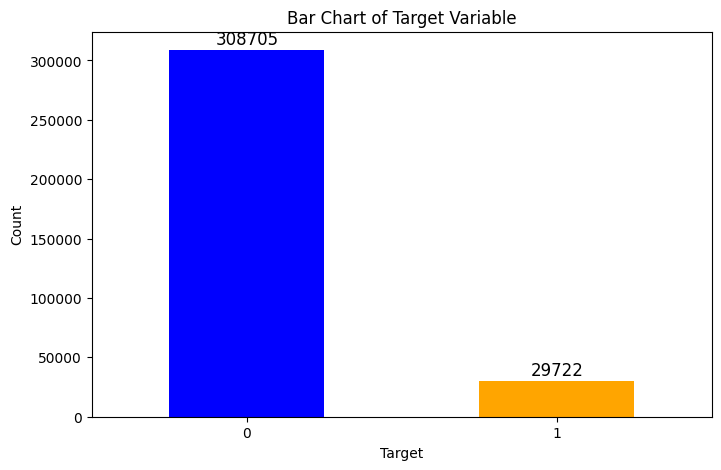

In [5]:
# 'TARGET' variable count
target_counts = df['TARGET'].value_counts()

# bar chart
plt.figure(figsize=(8, 5))
bars = target_counts.plot(kind='bar', color=['blue', 'orange'])
#bars.set_xticklabels(['No', 'Yes'])
plt.title('Bar Chart of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Adding total for every class
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='center',
                 size=12, xytext=(0, 8),
                 textcoords='offset points')

plt.show()

The target variable show a very high imbalance.

## 2. Data Preprocessing


In [6]:
df.isna().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,1
NAME_HOUSING_TYPE,1


Since there are a large number of null values ​​in the occupation type column (30% of the dataset) let's remove the entire column. For all other null values, since they are a limited number it is possible to remove the corresponding row.

In [7]:
#Drop Occupation_Type
df.drop('OCCUPATION_TYPE', axis=1, inplace=True)

#Drop na
df.dropna(axis=0, inplace=True)

df.isna().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In order to be used in a model, the variable CODE_GENDER, FLAG_OWN_CAR, FLAF_OWN_REALTY has to be coded.

In [8]:
#mapping
df['CODE_GENDER']=df['CODE_GENDER'].map({'F':0,'M':1})
df['FLAG_OWN_CAR']=df['FLAG_OWN_CAR'].map({'N':0,'Y':1})
df['FLAG_OWN_REALTY']=df['FLAG_OWN_REALTY'].map({'N':0,'Y':1})

For easier interpretation, let's replace the column DAYS_BIRTH with a column named AGE that reports the age expressed in years.

In [9]:
# Years conversion
df['AGE'] = (-(df['DAYS_BIRTH'] / 365.25)).astype(int)

# drop columns DaysBirth
df.drop(columns=['DAYS_BIRTH'], inplace=True)

From what seen before, DAYS_EMPLOYED is not usable, let's replace it with a column that indicates the employed/unemployed status.

In [10]:
#Work status
df['WORK_STATUS'] = df['DAYS_EMPLOYED'].apply(lambda x: 1 if x < 0 else 0)
df.drop(columns=['DAYS_EMPLOYED'], inplace=True)

The variable NAME_EDUCATION_TYPE is an ordinal categorical variable so it can be coded with numeric values.

In [11]:
df['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [12]:
education_mapping = {
    'Lower secondary': 1,
    'Secondary / secondary special': 2,
    'Incomplete higher': 3,
    'Higher education': 4,
    'Academic degree': 5}

df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map(education_mapping)

**2.1 Variable transformation**

For Nominal Categorical variable let's apply OneHotEncoder, for all the others let's use the standard scaler.

In [13]:
#Feature subdivision
categorical_features = ['NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']
numerical_features = [col for col in df.columns if col not in categorical_features and col!='ID' and col != 'TARGET']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

In [14]:
#Confusion matrix function
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    df_cm=pd.DataFrame(cm, index=['Negative','Positive'],
                       columns=['Predicted Negative','Predicted Positive'])

    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.show()

# 3. Predictive Model

**3.1 Logistic Regression**

In [15]:
X=df.drop(['ID','TARGET'], axis=1)
y=df['TARGET']

RANDOM_SEED=2

#Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

In [16]:
#Applying Preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


#Model fit
lr=LogisticRegression(class_weight='balanced',solver='liblinear',penalty='l1',random_state=RANDOM_SEED)

lr.fit(X_train, y_train)

#Evaluate y with model
y_pred_train=lr.predict(X_train)
y_pred_test=lr.predict(X_test)

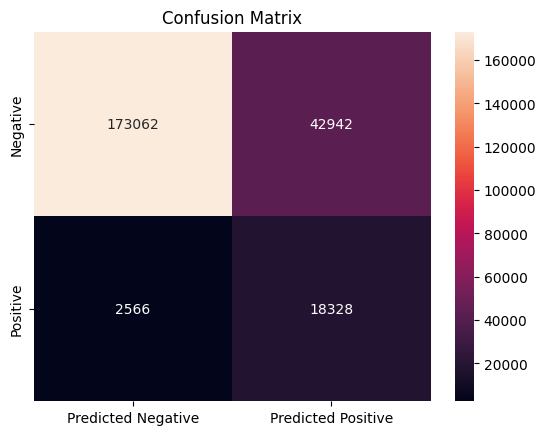

              precision    recall  f1-score   support

           0       0.99      0.80      0.88    216004
           1       0.30      0.88      0.45     20894

    accuracy                           0.81    236898
   macro avg       0.64      0.84      0.66    236898
weighted avg       0.92      0.81      0.85    236898



In [17]:
plot_confusion_matrix(y_train,y_pred_train)
print(classification_report(y_train, y_pred_train))

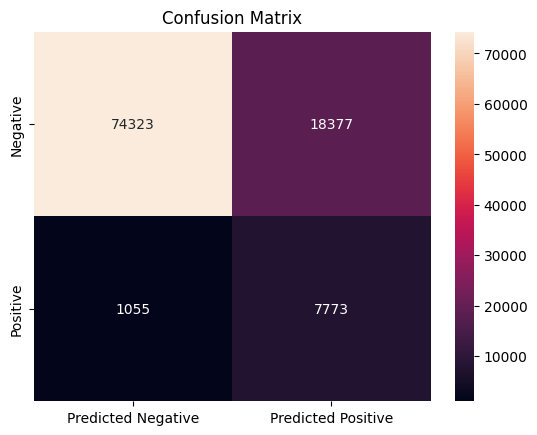

              precision    recall  f1-score   support

           0       0.99      0.80      0.88     92700
           1       0.30      0.88      0.44      8828

    accuracy                           0.81    101528
   macro avg       0.64      0.84      0.66    101528
weighted avg       0.93      0.81      0.85    101528



In [18]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

The model shows the same performance on both train and test set.

The overall accuracy is 81%, which indicates that the model has a good overall performance. However, the accuracy for class 1 is relatively low, which suggests that the model has difficulty in correctly distinguishing this class from class 0.

**3.2 Bernoulli NB**

In [19]:
#Feature subdivision
categorical_features = ['NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']
numerical_features = [col for col in df.columns if col not in categorical_features and col!='ID' and col != 'TARGET']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

model = BernoulliNB()

#Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#Applying Preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

model.fit(X_train, y_train)

#Evaluate y with model
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

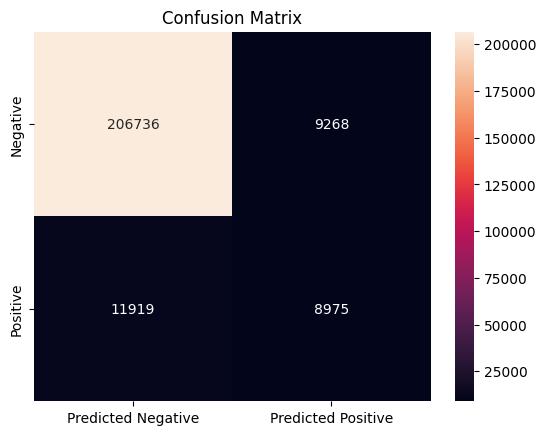

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    216004
           1       0.49      0.43      0.46     20894

    accuracy                           0.91    236898
   macro avg       0.72      0.69      0.70    236898
weighted avg       0.91      0.91      0.91    236898



In [20]:
plot_confusion_matrix(y_train,y_pred_train)
print(classification_report(y_train, y_pred_train))

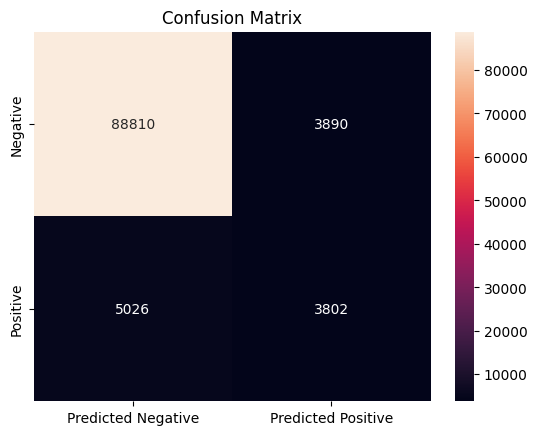

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     92700
           1       0.49      0.43      0.46      8828

    accuracy                           0.91    101528
   macro avg       0.72      0.69      0.71    101528
weighted avg       0.91      0.91      0.91    101528



In [21]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

The model shows the same performance on both train and test set.

Compared with Logistic Regression, the overall accuracy has increased of 10%. F1 score has increased for both classes.


Since the purpose of the model is to estimate creditworthiness, it is important to pay attention to false positives. In face off a 4% reduction in class 0 precision, there is a 19% increase in class 1 precision.

**3.2.1 Oversampling**

In [22]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

#split dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#resampling test set
X_train, y_train = oversample.fit_resample(X_train, y_train)

#Applying Preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

model = BernoulliNB()

model.fit(X_train, y_train)

#Evaluate y with model
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

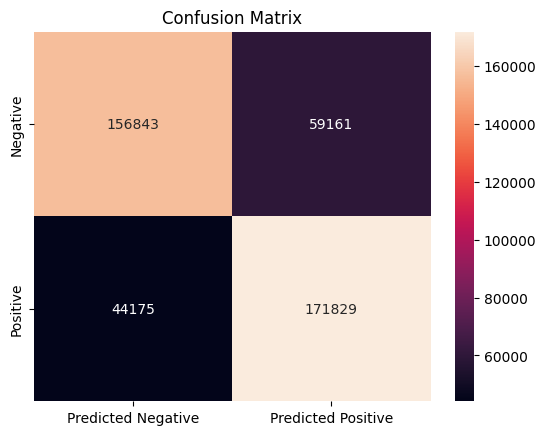

              precision    recall  f1-score   support

           0       0.78      0.73      0.75    216004
           1       0.74      0.80      0.77    216004

    accuracy                           0.76    432008
   macro avg       0.76      0.76      0.76    432008
weighted avg       0.76      0.76      0.76    432008



In [23]:
plot_confusion_matrix(y_train,y_pred_train)
print(classification_report(y_train, y_pred_train))

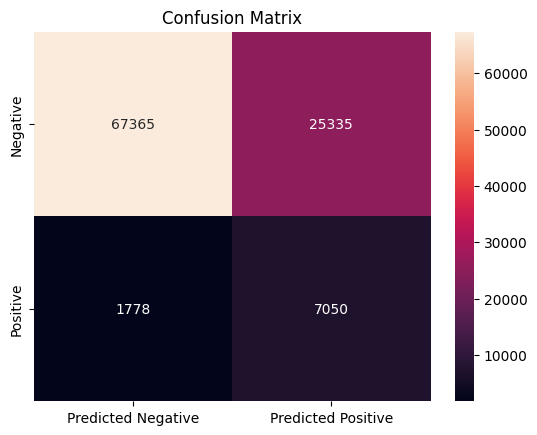

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     92700
           1       0.22      0.80      0.34      8828

    accuracy                           0.73    101528
   macro avg       0.60      0.76      0.59    101528
weighted avg       0.91      0.73      0.79    101528



In [24]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

The Bernoulli NB model fitted on the oversampled train set has worse performance then the ones fitted on the original train set.

**3.3 Complement NB**

In [25]:
#Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#Preprocesor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

#Applying Preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#model
model = ComplementNB()
model.fit(X_train, y_train)

#Evaluate y with model
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

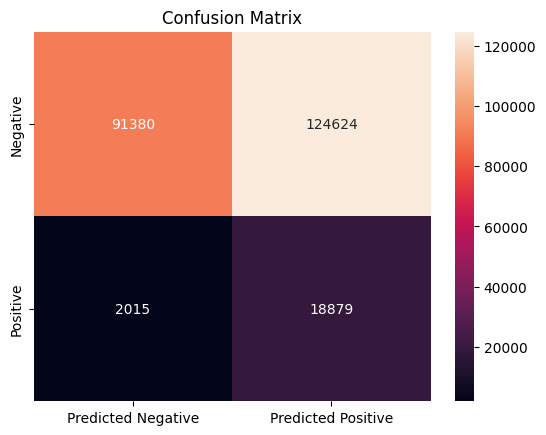

              precision    recall  f1-score   support

           0       0.98      0.42      0.59    216004
           1       0.13      0.90      0.23     20894

    accuracy                           0.47    236898
   macro avg       0.55      0.66      0.41    236898
weighted avg       0.90      0.47      0.56    236898



In [26]:
plot_confusion_matrix(y_train,y_pred_train)
print(classification_report(y_train, y_pred_train))

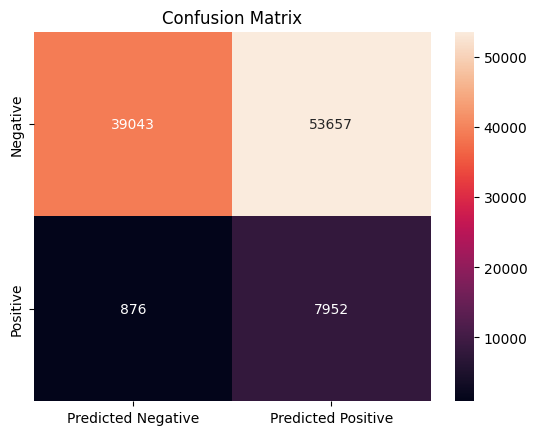

              precision    recall  f1-score   support

           0       0.98      0.42      0.59     92700
           1       0.13      0.90      0.23      8828

    accuracy                           0.46    101528
   macro avg       0.55      0.66      0.41    101528
weighted avg       0.90      0.46      0.56    101528



In [27]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

Complement NB performes worse than the Bernoulli NB.

# 4. Final Model

The model that achieves the best performance is the Bernoulli NB.

In [28]:
#Feature subdivision
categorical_features = ['NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']
numerical_features = [col for col in df.columns if col not in categorical_features and col!='ID' and col != 'TARGET']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

model = BernoulliNB()

#Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#Keep index
X_train_transf=preprocessor.fit_transform(X_train)
X_train_transf=pd.DataFrame(X_train_transf, index=X_train.index)
X_test_transf=preprocessor.transform(X_test)
X_test_transf=pd.DataFrame(X_test_transf, index=X_test.index)

#model fit
model.fit(X_train_transf,y_train)

#Evaluate y with model
y_pred_train=model.predict(X_train_transf)
y_pred_test=model.predict(X_test_transf)

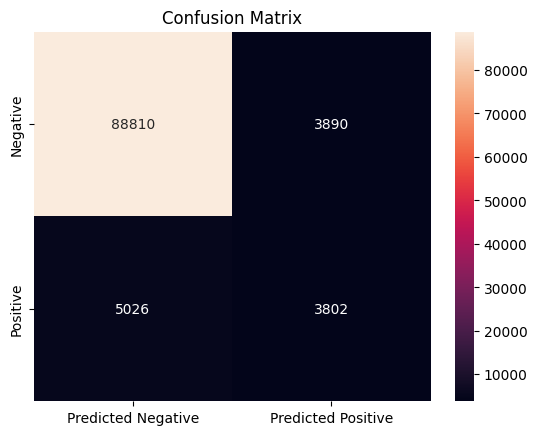

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     92700
           1       0.49      0.43      0.46      8828

    accuracy                           0.91    101528
   macro avg       0.72      0.69      0.71    101528
weighted avg       0.91      0.91      0.91    101528



In [29]:
plot_confusion_matrix(y_test,y_pred_test)
print(classification_report(y_test, y_pred_test))

The model has an accury of 91% that means the model correctly classified 91% of the total cases. Precision and recall for class 1 are low, indicating that the model may not be adequate to correctly identify positive cases. This is probably due to the fact that dataset is dominated by obsarvations belonging to class 0.

Since the model is designed to predict creditworthiness, and considering that the model has a F1 score of 95% on class 0, the model can be considered valid.

The model is able to filter out most of the unreliable customers. As for reliable customers, in the case of a negative prediction, it can always be done a deeper analysis and then release the credit card.


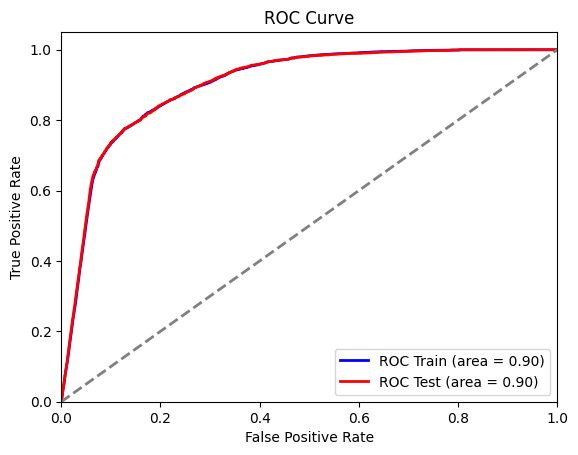

In [30]:
y_proba_train=model.predict_proba(X_train_transf)[:, 1]
y_proba_test=model.predict_proba(X_test_transf)[:, 1]

# Evaluate false positive ratio and true positive ratio
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)


# Roc Curve
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'ROC Train (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'ROC Test (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

An AUC value of 0.90 for both datasets (train and test) indicates that the model has a good performance in distinguish between positive and negative classes.

The ROC curves for the train and test sets are very similar, suggesting is not overfitted.

**4.1 Prediction explaination**

To understand why the model outputs a certain prediction, it is possible to analyze the contribution of the various features to the prediction.

In [31]:
#explainer
explainer=shap.Explainer(model.predict_proba, X_train_transf)

#Evaluete feature names after transforming dataset
#only features affected by ohe has changed name
ohe = preprocessor.named_transformers_['cat']  # OneHotEncoder
categorical_feature_names = ohe.get_feature_names_out(categorical_features)
numerical_feature_names = numerical_features
new_feature_names = list(numerical_feature_names) + list(categorical_feature_names)

In [32]:
#Explaination Function
def single_prediction_explainaition(explainer, X, new_feature_names, index=0, df=None, y=None):
  """
  Evauluate explaination for a single prediction

  explainer: shap explainer
  X: dataset to be evaluated
  y: predicted target variable
  index [int] : index of the prediction
  new_features_name [list]: list of features names of the model
  df [DataFrame]: original dataset containing the 'ID' column
  """
  if df is None:
    instance_id="Unknown"
  else:
    # Retrieve ID
    instance_index = X.index[index]
    instance_id = df.loc[instance_index, 'ID']

  #evaluate shap values for dataser X
  shap_values= explainer(X)

  #Shap object for a single istance
  shap_explanation = shap.Explanation(
    values=shap_values[index, :, 1],
    feature_names=new_feature_names)

  # Create the waterfall plot
  fig, ax = plt.subplots()
  shap.plots.waterfall(shap_explanation, show=False)

  # Add title to the same plot
  ax.set_title(f"Predicted value explaination for ID: {instance_id}",
               fontsize=16, x=0.2)

  # Add an annotation with the predicted value
  if y is not None:
    predicted_value = y[index]
    if predicted_value==0:
      predicted_value="Rejected"
    else:
      predicted_value="Approved"
    # Position the text above the plot
    ax.text(-0.5, -0.1, f"Predicted Value: {predicted_value}",
            fontsize=14, color='black', weight='bold', ha='center',
            transform=ax.transAxes)

  # Show the plot
  plt.show()

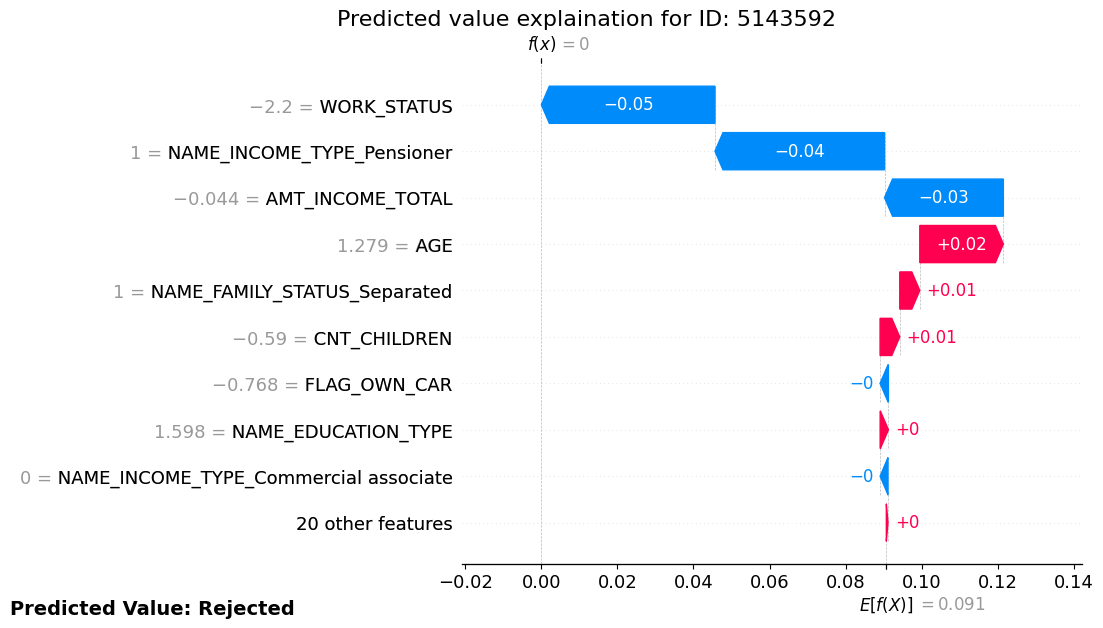

In [33]:
#Considering the first 10 row of X_test
X_exp=X_test_transf.iloc[0:10,:]
y_exp_pred=model.predict(X_exp)
#Evaluating the explainaition for a specific observation
istance=0
single_prediction_explainaition(explainer, X_exp, new_feature_names, index=istance, df=df, y=y_exp_pred)

The graph shows, for the analyzed case, the contribution of the various features to the prediction of the model. From the graph it is possible to note that the features that have most influenced the prediction are:

- **WORK_STATUS**
- **NAME_INCOME_TYPE**
- **AMT_INCOME_TOTAL**

For that specific case, beeing retired and therefore unemployed combinend with a low total annual income has contributed to a negative response.